In [1]:
import numpy 
import keras
from keras.layers import *
from keras.models import *
import keras.backend as K


C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
seqlen = 10
batch_size = 32
epochs = 50

In [3]:
def generator(batch_size=8):
    Xs, Ys = [], []
    while True:
        step = np.random.randint(3)
        f0 = np.random.randint(-10, 10)
        x = [f0]
        for _ in range(seqlen):
            f0 += step
            x.append(f0)
        Xs.append(x[:seqlen])
        Ys.append(x[seqlen])
        if len(Xs)==batch_size:
            yield np.expand_dims(np.array(Xs), -1), np.array(Ys)
            Xs, Ys = [], []

In [4]:
next(generator())

(array([[[ 5],
         [ 6],
         [ 7],
         [ 8],
         [ 9],
         [10],
         [11],
         [12],
         [13],
         [14]],
 
        [[-6],
         [-5],
         [-4],
         [-3],
         [-2],
         [-1],
         [ 0],
         [ 1],
         [ 2],
         [ 3]],
 
        [[-4],
         [-4],
         [-4],
         [-4],
         [-4],
         [-4],
         [-4],
         [-4],
         [-4],
         [-4]],
 
        [[-7],
         [-7],
         [-7],
         [-7],
         [-7],
         [-7],
         [-7],
         [-7],
         [-7],
         [-7]],
 
        [[-2],
         [-2],
         [-2],
         [-2],
         [-2],
         [-2],
         [-2],
         [-2],
         [-2],
         [-2]],
 
        [[ 9],
         [11],
         [13],
         [15],
         [17],
         [19],
         [21],
         [23],
         [25],
         [27]],
 
        [[ 3],
         [ 4],
         [ 5],
         [ 6],
         [ 7],
       

In [5]:
# custom R2-score metrics for keras backend
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

model = Sequential()
model.add(CuDNNLSTM(128, recurrent_regularizer=keras.regularizers.l2(0.01), return_sequences=True, input_shape=(seqlen,1)))
model.add(CuDNNLSTM(128, recurrent_regularizer=keras.regularizers.l2(0.01), return_sequences=True))
model.add(CuDNNLSTM(128, recurrent_regularizer=keras.regularizers.l2(0.01), return_sequences=False))
model.add(Dense(1, kernel_regularizer=keras.regularizers.l2(0.001)))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=[r2_keras])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 10, 128)           67072     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 10, 128)           132096    
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 331,393
Trainable params: 331,393
Non-trainable params: 0
_________________________________________________________________


In [6]:
train_generator = generator(batch_size=batch_size)
valid_generator = generator(batch_size=batch_size)

history = model.fit_generator(train_generator, steps_per_epoch=1000, epochs=epochs, validation_data=valid_generator, validation_steps=100)

Epoch 1/50
1000/1000 [==============================] - 20s 20ms/step - loss: 3.8409 - r2_keras: 0.9715 - val_loss: 1.6508 - val_r2_keras: 0.9855
Epoch 2/50
1000/1000 [==============================] - 18s 18ms/step - loss: 0.4953 - r2_keras: 0.9967 - val_loss: 0.1478 - val_r2_keras: 0.9996
Epoch 3/50
1000/1000 [==============================] - 18s 18ms/step - loss: 0.2712 - r2_keras: 0.9980 - val_loss: 0.1000 - val_r2_keras: 0.9996
Epoch 4/50
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1838 - r2_keras: 0.9986 - val_loss: 0.0588 - val_r2_keras: 0.9999
Epoch 5/50
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1533 - r2_keras: 0.9988 - val_loss: 0.0585 - val_r2_keras: 0.9998
Epoch 6/50
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1184 - r2_keras: 0.9991 - val_loss: 0.0348 - val_r2_keras: 0.9999
Epoch 7/50
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1051 - r2_keras: 0.9991 - val_loss: 0.0534 -

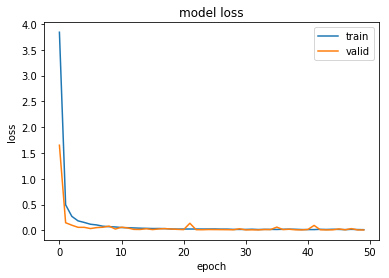

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper right')
plt.show()

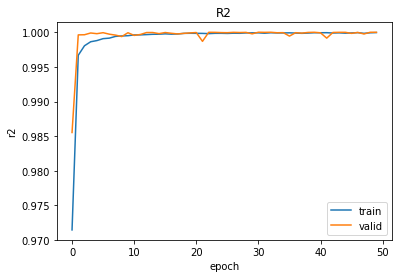

In [10]:
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('R2')
plt.ylabel('r2')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='lower right')
plt.show()

In [15]:
x = np.array([list(range(10)), [2]*10, [0]*10, list(range(5, 15))])[..., np.newaxis]
y = np.squeeze(model.predict(x)) # expect '10, 2, 0, 15'
print(y)
print(y.round())

[1.0027253e+01 2.0080340e+00 4.1052997e-03 1.4987120e+01]
[10.  2.  0. 15.]
